In [16]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import os

In [17]:
IMG_SIZE = 300
BATCH_SIZE = 32
EPOCHS = 10
DATASET_PATH = '/content/your_dataset_folder'  # change this if your dataset is in a different folder


In [18]:
# --- DATA GENERATORS ---
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    horizontal_flip=True,
    zoom_range=0.2,
    rotation_range=20
)

valid_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    os.path.join(DATASET_PATH, 'train'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

valid_generator = valid_datagen.flow_from_directory(
    os.path.join(DATASET_PATH, 'valid'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(DATASET_PATH, 'test'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 14213 images belonging to 2 classes.
Found 2427 images belonging to 2 classes.
Found 1184 images belonging to 2 classes.


In [19]:
# --- MODEL BUILDING ---
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification output

model = Model(inputs=base_model.input, outputs=predictions)


In [20]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 300, 300,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 300, 300,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 300, 300,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 301, 301,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 150, 150,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 150, 150,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 150, 150,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 150, 150,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 150, 150,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 150, 150,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 150, 150,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 150, 150,  │        960 │ block1a_se_excit

 Total params: 11,177,264 (42.64 MB)

 Trainable params: 11,089,961 (42.30 MB)

 Non-trainable params: 87,303 (341.03 KB)

In [21]:
# --- COMPILE MODEL ---
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# --- TRAIN MODEL ---
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=valid_generator
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8296 - loss: 0.3598

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


445/445 ━━━━━━━━━━━━━━━━━━━━ 645s 1s/step - accuracy: 0.8298 - loss: 0.3596 - val_accuracy: 0.9543 - val_loss: 0.1263
Epoch 2/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 451s 1s/step - accuracy: 0.9505 - loss: 0.1317 - val_accuracy: 0.9674 - val_loss: 0.0825
Epoch 3/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 457s 1s/step - accuracy: 0.9701 - loss: 0.0838 - val_accuracy: 0.9666 - val_loss: 0.0888
Epoch 4/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 460s 1s/step - accuracy: 0.9771 - loss: 0.0668 - val_accuracy: 0.9670 - val_loss: 0.1000
Epoch 5/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 456s 1s/step - accuracy: 0.9818 - loss: 0.0493 - val_accuracy: 0.9732 - val_loss: 0.0790
Epoch 6/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 452s 1s/step - accuracy: 0.9805 - loss: 0.0466 - val_accuracy: 0.9720 - val_loss: 0.0928
Epoch 7/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 450s 1s/step - accuracy: 0.9884 - loss: 0.0322 - val_accuracy: 0.9633 - val_loss: 0.1123
Epoch 8/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 458s 1s/step - accuracy: 0.9888 - loss: 0.0349 - val_accuracy: 0.970

In [22]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 187ms/step - accuracy: 0.9830 - loss: 0.0653
Test Accuracy: 0.9806


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


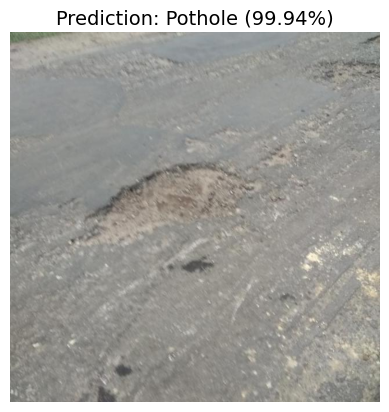

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import tensorflow as tf

# --- SETTINGS ---
IMG_SIZE = 300  # Should match the model's input
img_path = '/content/your_dataset_folder/test/Pothole/1113_jpg.rf.73eec04d5bfee2f0644e23e457122a07.jpg'  # 🔁 Replace this with your image path

# --- LOAD AND PREPROCESS IMAGE ---
img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
img_array = image.img_to_array(img)
img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# --- PREDICT ---
prediction = model.predict(img_array)[0][0]  # Get the probability

# --- INTERPRET AND DISPLAY ---
label = "Pothole" if prediction > 0.5 else "No Pothole"
confidence = prediction if prediction > 0.5 else 1 - prediction

plt.imshow(image.load_img(img_path))
plt.title(f"Prediction: {label} ({confidence*100:.2f}%)", fontsize=14)
plt.axis('off')
plt.show()


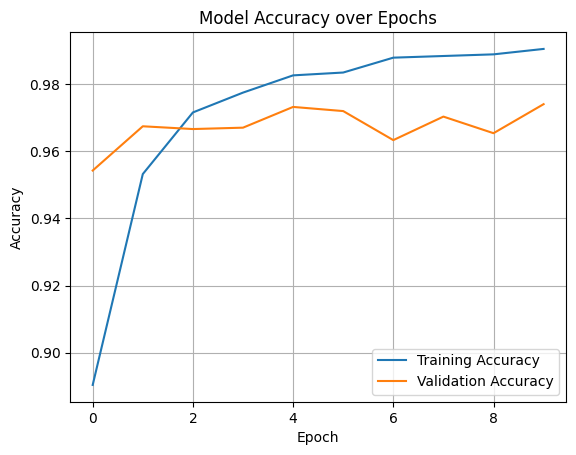

In [30]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [31]:
from tensorflow.keras.callbacks import Callback

class TestAccuracyCallback(Callback):
    def __init__(self, test_generator):
        super().__init__()
        self.test_generator = test_generator
        self.test_accuracies = []

    def on_epoch_end(self, epoch, logs=None):
        loss, acc = self.model.evaluate(
            self.test_generator,
            steps=self.test_generator.samples // self.test_generator.batch_size,
            verbose=0
        )
        self.test_accuracies.append(acc)
        print(f"\nTest accuracy after epoch {epoch+1}: {acc:.4f}")

In [32]:
# Initialize the callback
test_callback = TestAccuracyCallback(test_generator)

# Train the model with the callback
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size,
    callbacks=[test_callback]
)


Epoch 1/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 919ms/step - accuracy: 0.9919 - loss: 0.0234
Test accuracy after epoch 1: 0.9747
444/444 ━━━━━━━━━━━━━━━━━━━━ 430s 967ms/step - accuracy: 0.9919 - loss: 0.0234 - val_accuracy: 0.9750 - val_loss: 0.1097
Epoch 2/10
  1/444 ━━━━━━━━━━━━━━━━━━━━ 3:15 442ms/step - accuracy: 1.0000 - loss: 0.0049

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Test accuracy after epoch 2: 0.9747
444/444 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 1.0000 - loss: 0.0049 - val_accuracy: 0.9746 - val_loss: 0.1123
Epoch 3/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 911ms/step - accuracy: 0.9922 - loss: 0.0196
Test accuracy after epoch 3: 0.9688
444/444 ━━━━━━━━━━━━━━━━━━━━ 442s 994ms/step - accuracy: 0.9922 - loss: 0.0196 - val_accuracy: 0.9679 - val_loss: 0.1291
Epoch 4/10
  1/444 ━━━━━━━━━━━━━━━━━━━━ 3:12 435ms/step - accuracy: 0.9688 - loss: 0.0875

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Test accuracy after epoch 4: 0.9679
444/444 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - accuracy: 0.9688 - loss: 0.0875 - val_accuracy: 0.9683 - val_loss: 0.1277
Epoch 5/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 898ms/step - accuracy: 0.9932 - loss: 0.0192
Test accuracy after epoch 5: 0.9645
444/444 ━━━━━━━━━━━━━━━━━━━━ 419s 944ms/step - accuracy: 0.9932 - loss: 0.0192 - val_accuracy: 0.9675 - val_loss: 0.1370
Epoch 6/10
  1/444 ━━━━━━━━━━━━━━━━━━━━ 3:12 436ms/step - accuracy: 0.9688 - loss: 0.0386

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Test accuracy after epoch 6: 0.9637
444/444 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - accuracy: 0.9688 - loss: 0.0386 - val_accuracy: 0.9679 - val_loss: 0.1391
Epoch 7/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 896ms/step - accuracy: 0.9944 - loss: 0.0179
Test accuracy after epoch 7: 0.9780
444/444 ━━━━━━━━━━━━━━━━━━━━ 419s 943ms/step - accuracy: 0.9944 - loss: 0.0179 - val_accuracy: 0.9700 - val_loss: 0.1096
Epoch 8/10
  1/444 ━━━━━━━━━━━━━━━━━━━━ 3:19 451ms/step - accuracy: 1.0000 - loss: 0.0019

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Test accuracy after epoch 8: 0.9780
444/444 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.9700 - val_loss: 0.1107
Epoch 9/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 900ms/step - accuracy: 0.9940 - loss: 0.0188
Test accuracy after epoch 9: 0.9721
444/444 ━━━━━━━━━━━━━━━━━━━━ 442s 987ms/step - accuracy: 0.9940 - loss: 0.0188 - val_accuracy: 0.9700 - val_loss: 0.1350
Epoch 10/10
  1/444 ━━━━━━━━━━━━━━━━━━━━ 3:12 434ms/step - accuracy: 1.0000 - loss: 0.0042

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Test accuracy after epoch 10: 0.9721
444/444 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 1.0000 - loss: 0.0042 - val_accuracy: 0.9696 - val_loss: 0.1382


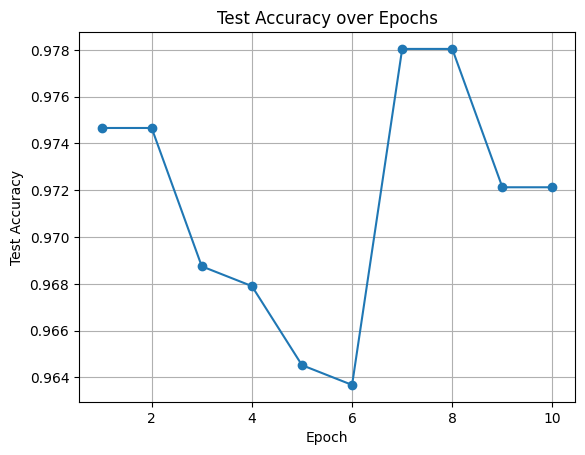

In [33]:
# Plot test accuracy per epoch
plt.plot(range(1, len(test_callback.test_accuracies) + 1), test_callback.test_accuracies, marker='o')
plt.title('Test Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.grid(True)
plt.show()

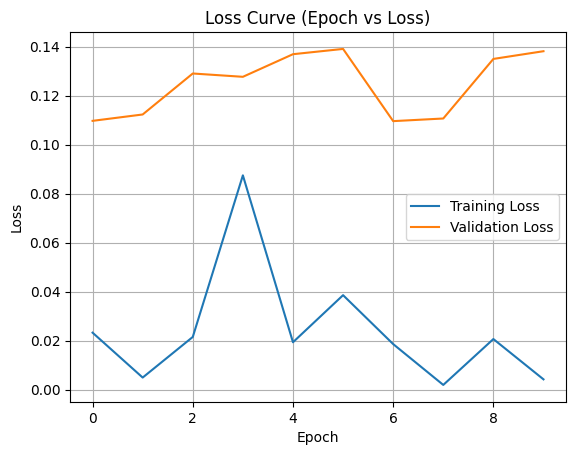

In [35]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Loss Curve (Epoch vs Loss)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [36]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Reset the generator to start from the beginning
train_generator.reset()

# Initialize lists for true labels and predictions
train_labels = []
train_predictions = []

# Iterate through the batches
for i in range(train_generator.samples // train_generator.batch_size):
    images, labels = next(train_generator)  # Get batch
    predictions = model.predict(images, verbose=0)  # Predict batch
    train_labels.extend(labels)
    train_predictions.extend(np.round(predictions))  # Round to 0 or 1

# Convert to numpy arrays
train_labels = np.array(train_labels).astype(int)
train_predictions = np.array(train_predictions).astype(int)

# Generate and print confusion matrix
cm_train = confusion_matrix(train_labels, train_predictions)
print("Confusion Matrix for Training Data:")
print(cm_train)


Confusion Matrix for Training Data:
[[6867   27]
 [  38 7276]]


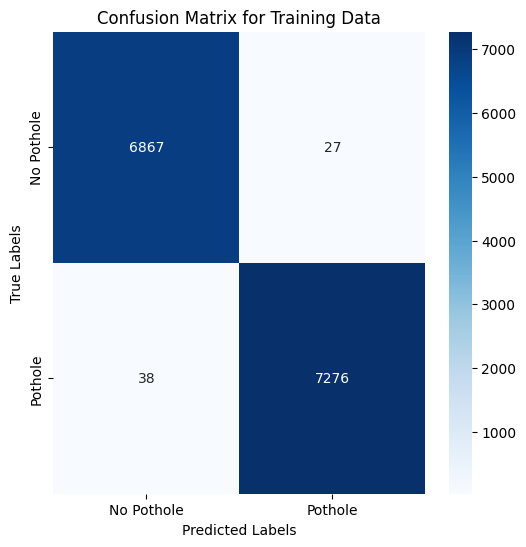

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix for the training data
cm_train = confusion_matrix(train_labels, train_predictions)

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=['No Pothole', 'Pothole'], yticklabels=['No Pothole', 'Pothole'])
plt.title('Confusion Matrix for Training Data')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [38]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Assuming train_labels and train_predictions are already defined (from previous steps)

# Calculate Accuracy
accuracy = accuracy_score(train_labels, train_predictions)
print(f"Accuracy: {accuracy:.4f}")

# Calculate Precision
precision = precision_score(train_labels, train_predictions)
print(f"Precision: {precision:.4f}")

# Calculate Recall
recall = recall_score(train_labels, train_predictions)
print(f"Recall: {recall:.4f}")

# Calculate F1 Score
f1 = f1_score(train_labels, train_predictions)
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9954
Precision: 0.9963
Recall: 0.9948
F1 Score: 0.9956


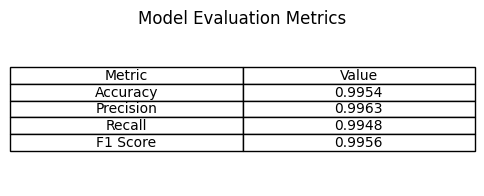

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Calculate the metrics
accuracy = accuracy_score(train_labels, train_predictions)
precision = precision_score(train_labels, train_predictions)
recall = recall_score(train_labels, train_predictions)
f1 = f1_score(train_labels, train_predictions)

# Create the data for the table
metrics = [
    ['Accuracy', f'{accuracy:.4f}'],
    ['Precision', f'{precision:.4f}'],
    ['Recall', f'{recall:.4f}'],
    ['F1 Score', f'{f1:.4f}']
]

# Plotting the table
fig, ax = plt.subplots(figsize=(6, 2))  # Set size of the figure
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=metrics, colLabels=['Metric', 'Value'], loc='center', cellLoc='center')

# Display the table
plt.title("Model Evaluation Metrics")
plt.show()

In [40]:
# Save the model
model.save('EfficientNetB3.h5')  # Save as a .h5 file

print("Model saved successfully!")

Model saved successfully!
